In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import cv2
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from skimage.color import rgb2gray
import numpy as np

%matplotlib inline

In [115]:
# https://michhar.github.io/masks_to_polygons_and_back/
# https://github.com/michhar/python-jupyter-notebooks/blob/master/datatools/DealingWithGeospatialImages.ipynb

def mask_to_polygons(mask, epsilon=10., min_area=10.):
    """Convert a mask ndarray (binarized image) to Multipolygons"""
    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(mask,
                                  cv2.RETR_CCOMP,
                                  cv2.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    all_polygons = MultiPolygon(all_polygons)

    return all_polygons


def mask_for_polygons(polygons, im_size):
    """Convert a polygon or multipolygon list back to
       an image mask ndarray"""
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    # function to round and convert to int
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

In [157]:
test_polygon = Polygon([(0, 0), (2, 2), (4, 5), (8,2)])

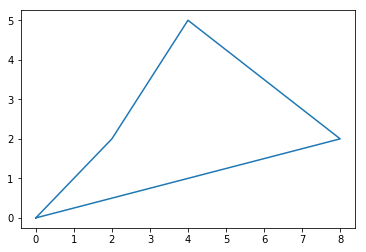

In [158]:
plt.plot(*test_polygon.exterior.xy)

In [159]:
test_mask = mask_for_polygons([test_polygon], im_size=(10,10))
test_mask

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

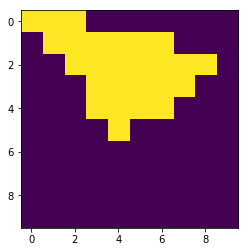

In [160]:
test_img = plt.imshow(test_mask)
test_img

In [162]:
contours, hierarchy = cv2.findContours(test_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

In [163]:
contours, hierarchy

([array([[[0, 0]],
  
         [[1, 1]],
  
         [[2, 2]],
  
         [[3, 3]],
  
         [[3, 4]],
  
         [[4, 5]],
  
         [[5, 4]],
  
         [[6, 4]],
  
         [[7, 3]],
  
         [[8, 2]],
  
         [[7, 2]],
  
         [[6, 1]],
  
         [[5, 1]],
  
         [[4, 1]],
  
         [[3, 1]],
  
         [[2, 0]],
  
         [[1, 0]]], dtype=int32)], array([[[-1, -1, -1, -1]]], dtype=int32))

In [168]:
contours[0][0][0]

array([0, 0], dtype=int32)

In [170]:
contours_tuples = [tuple(xy[0]) for xy in contours[0]]

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (3, 4),
 (4, 5),
 (5, 4),
 (6, 4),
 (7, 3),
 (8, 2),
 (7, 2),
 (6, 1),
 (5, 1),
 (4, 1),
 (3, 1),
 (2, 0),
 (1, 0)]

In [171]:
test_polygon_reconstructed = Polygon(contours_tuples)

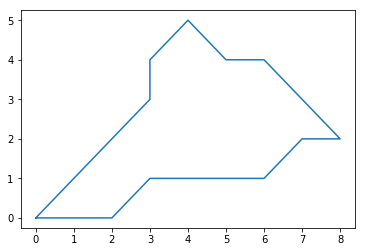

In [174]:
plt.plot(*test_polygon_reconstructed.exterior.xy)

([<matplotlib.lines.Line2D at 0x1c2eaf5490>],
 <matplotlib.image.AxesImage at 0x1c2eaf5a10>)

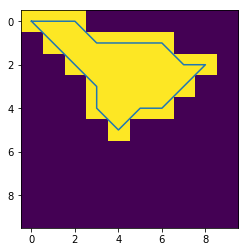

In [173]:
plt.plot(*test_polygon_reconstructed.exterior.xy), plt.imshow(test_mask)

In [176]:
all_test_polygons = mask_to_polygons(test_mask, epsilon=10., min_area=10.)

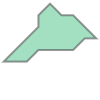

In [177]:
all_test_polygons

In [178]:
# warning! Mind up and down, left, right! (where is the zero on the axis)